In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

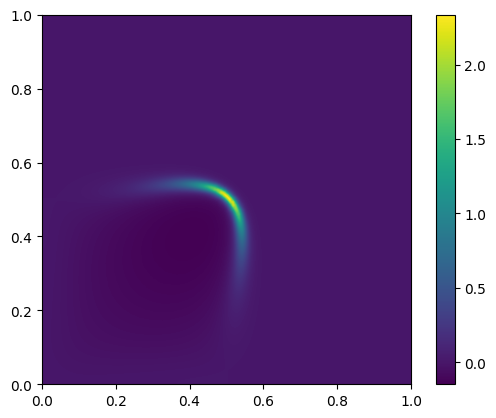

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

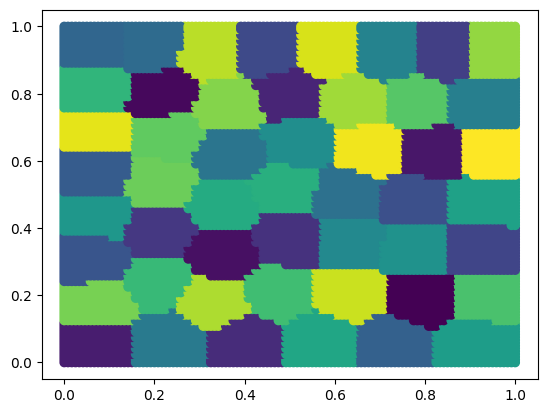

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [10]:
group_indices = []
for i in range(m):
    group_indices.append(torch.tensor(np.where(clustering.labels_ == i)[0], device=device))

In [11]:
N = datas.shape[1] // 2
n = 100
mu = int(np.ceil(N/200))
_, neighbours = lib.utils.topk_neighbours(coords, mu)

In [12]:
batch_size = 50
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [13]:
ed = lib.nrbs_test.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbours=neighbours, group_indices=group_indices, device=device)

In [14]:
# encoded = ed.nrbs.encode(datas[:15].to(device))

In [15]:
# encoded.shape

In [16]:
# decoded = ed.nrbs.decode(encoded)

In [17]:
# decoded.shape

In [18]:
ed.nrbs = torch.load('models/nrbs_n_m_test.pth')

In [19]:
# ed.train(train_data_loader=train_data, epochs=1000)

In [20]:
# ed.nrbs = torch.load('models/nrbs_n_m_test.pth')

In [21]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

In [22]:
approximates[0]

tensor([ 3.2119e-03,  1.5639e-03,  2.1944e-03,  ...,  5.2830e-05,
         1.8457e-04, -1.0686e-04], device='cuda:0', grad_fn=<SelectBackward0>)

In [23]:
datas[999:1001, N:]

tensor([[2.5000e-03, 2.4000e-03, 2.2500e-03,  ..., 4.8000e-30, 4.8000e-30,
         6.9900e-30]])

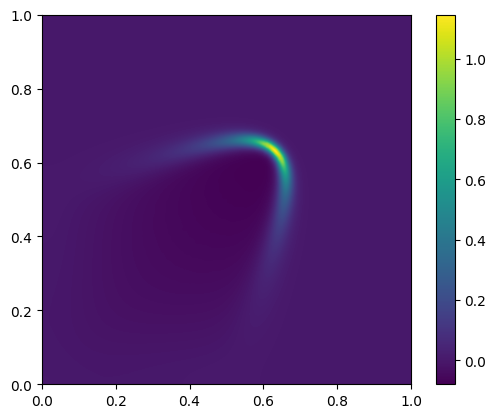

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

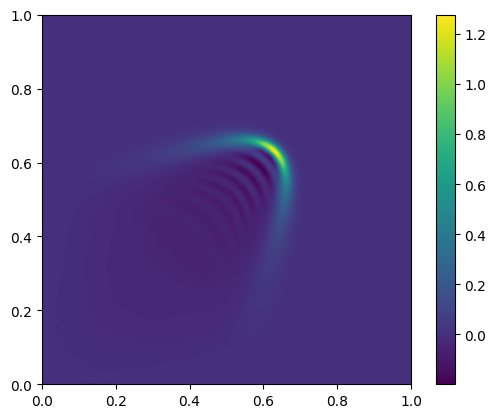

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [26]:
err = abs(datas[999] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

RuntimeError: The size of tensor a (29282) must match the size of tensor b (14641) at non-singleton dimension 0

In [28]:
encoded = ed.nrbs.encode(datas[999, :N].to(device).to(device))

In [29]:
encoded.shape

torch.Size([100])

In [33]:
bandwidths = torch.bmm(
            encoded.repeat(n, 1, 1), ed.nrbs.bandwidth_layers
        ).permute(1, 0, 2)
bandwidths = torch.sigmoid(bandwidths) / 60

In [35]:
basis_id = 0
bandwidths_loc = torch.zeros((N,))
for i in range(m):
    bandwidths_loc[np.where(clustering.labels_ == i)[0]] = bandwidths[:,basis_id,:][0][i]

In [ ]:
bandwidths[:,basis_id,:][0][i]

tensor(0.6739)

In [ ]:
bandwidths_loc.shape

torch.Size([14641])

In [ ]:
clustering.labels_.shape

(14641,)

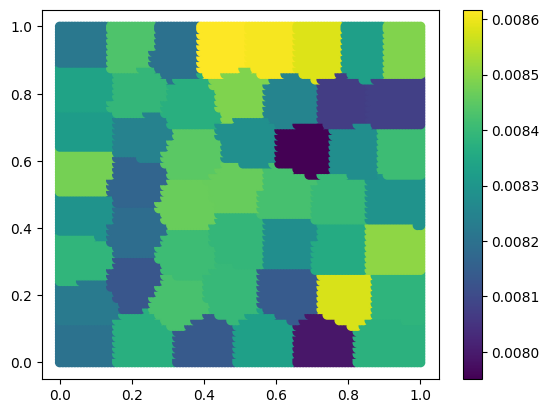

In [37]:
plt.scatter(coords_x, coords_y,c=bandwidths_loc.detach().cpu())
plt.colorbar()

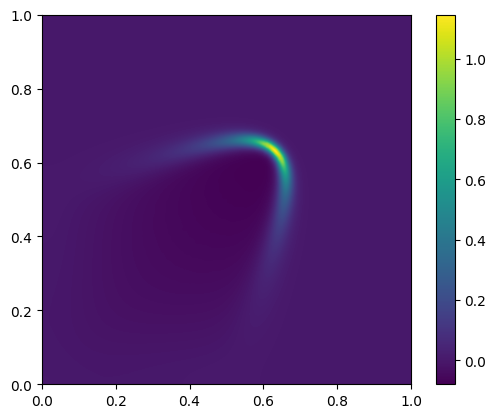

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
max(bandwidths_loc)

tensor(0.8127)

In [ ]:
min(bandwidths_loc)

tensor(0.3064)

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()